In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.get_npr_data()
df.head()

The df has 1889857 rows and 12 columns.


,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [3]:
df = df.sample(20_000)

In [4]:
# df['utterance_length'] = len(df.utterance.split())
df['utterance_word_count'] = df.utterance.apply(str.split).apply(len)
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count
2429438,55598,157,mr. evan tracey,"Right, and your caller brought up a good point...",talk of the nation,"political attack ads work, but are they true?",False,"right , and your caller brought up a good poin...","right , and your caller brought up a good poin...",0.4404,2010-09-29,65
1705259,129510,28,steve inskeep,While her simulated three-year old demands att...,morning edition,a city steps up: savannah confronts poverty,True,while her simulated three year old demands att...,while her simulated three year old demand atte...,-0.1280,2006-03-20,11
42996,52147,19,jessica taylor byline,The Statehouse speaker has said the legislatur...,weekend edition sunday,can the south carolina gop get rid of its conf...,False,the statehouse speaker has said the legislatur...,the statehouse speaker ha said the legislature...,0.5859,2015-07-26,50
581646,64611,48,will shortz byline,That's it - the name Clark.,weekend edition sunday,"to cross this puzzle safely, look left and right",False,that s it the name clark .,that s it the name clark .,0.0000,2012-04-29,6
3007553,91375,18,laura sydell byline,You're welcome.,morning edition,yahoo threatened with huge fines if it didn't ...,False,you re welcome .,you re welcome .,0.4588,2014-09-12,2


#### A quick lesson on .apply:

In [5]:
df['question_mark_count'] = df.utterance.str.count(r"[\?]")
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count,question_mark_count
2429438,55598,157,mr. evan tracey,"Right, and your caller brought up a good point...",talk of the nation,"political attack ads work, but are they true?",False,"right , and your caller brought up a good poin...","right , and your caller brought up a good poin...",0.4404,2010-09-29,65,0
1705259,129510,28,steve inskeep,While her simulated three-year old demands att...,morning edition,a city steps up: savannah confronts poverty,True,while her simulated three year old demands att...,while her simulated three year old demand atte...,-0.1280,2006-03-20,11,0
42996,52147,19,jessica taylor byline,The Statehouse speaker has said the legislatur...,weekend edition sunday,can the south carolina gop get rid of its conf...,False,the statehouse speaker has said the legislatur...,the statehouse speaker ha said the legislature...,0.5859,2015-07-26,50,0
581646,64611,48,will shortz byline,That's it - the name Clark.,weekend edition sunday,"to cross this puzzle safely, look left and right",False,that s it the name clark .,that s it the name clark .,0.0000,2012-04-29,6,0
3007553,91375,18,laura sydell byline,You're welcome.,morning edition,yahoo threatened with huge fines if it didn't ...,False,you re welcome .,you re welcome .,0.4588,2014-09-12,2,0


## Who asks the most questions?

In [6]:
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,speaker,count
5803,neal conan,2703
2208,ira flatow,773
6969,steve inskeep,631
6541,robert siegel,479
3348,melissa block,445
6384,renee montagne,413
1815,farai chideya,375
6720,scott simon,372
1074,david greene,324
6325,rachel martin,306


In [7]:
questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [8]:
questions = questions.merge(df, how='left', on='speaker').drop(columns=['story_id_num', 'utterance_order', 'utterance',
       'title','clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'])
questions

,speaker,count,program,is_host,date
0,neal conan,2703,talk of the nation,True,2006-10-11
1,neal conan,2703,talk of the nation,True,2007-03-13
2,neal conan,2703,talk of the nation,True,2013-04-09
3,neal conan,2703,talk of the nation,True,2010-08-24
4,neal conan,2703,talk of the nation,True,2007-02-19
...,...,...,...,...,...
19995,ken connelly,1,morning edition,False,2014-08-14
19996,kemba smith,1,talk of the nation,False,2008-12-17
19997,kelly traw,1,morning edition,False,2010-11-12
19998,kelly maguire,1,talk of the nation,False,2011-09-16


In [9]:
df=df.set_index('date').sort_index()

In [10]:
host_df = df[df.is_host==True]

In [11]:
guest_df = df[df.is_host!=True]

In [12]:
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

- This is a list of the 12 hosts with the most observations

In [13]:
# hosts_with_the_most

In [14]:
top_hosts_df = df[df.speaker.isin(hosts_with_the_most)]


In [15]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84433,21,neal conan,"And also worked at various times--well, he was...",talk of the nation,bush picks judge to head homeland security,True,"and also worked at various times well , he was...","and also worked at various time well , he wa i...",0.4386,37,0


In [16]:
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84430,81,ina jaffe reporting,"Hi, Neal.",talk of the nation,state legislatures: agendas and budgets,False,"hi , neal .","hi , neal .",0.0000,2,0
2005-01-11,84433,21,neal conan,"And also worked at various times--well, he was...",talk of the nation,bush picks judge to head homeland security,True,"and also worked at various times well , he was...","and also worked at various time well , he wa i...",0.4386,37,0
2005-01-11,84432,19,neal conan,"And one of the things you point out, again, is...",talk of the nation,difference between a think and a 'blink',True,"and one of the things you point out , again , ...","and one of the thing you point out , again , i...",0.2053,70,0
2005-01-11,84430,21,neal conan,And let's get a listener involved in the conve...,talk of the nation,state legislatures: agendas and budgets,True,and let s get a listener involved in the conve...,and let s get a listener involved in the conve...,0.0000,15,0
2005-01-26,84356,10,neal conan,You went on to Harvard and a life before you w...,talk of the nation,spy and tell: ex-cia agents write what they know,True,you went on to harvard and a life before you w...,you went on to harvard and a life before you w...,-0.2732,19,1


In [17]:
cluster_df= df[['vader','utterance_word_count','question_mark_count']]

array([[<AxesSubplot:title={'center':'vader'}>,
        <AxesSubplot:title={'center':'utterance_word_count'}>],
       [<AxesSubplot:title={'center':'question_mark_count'}>,
        <AxesSubplot:>]], dtype=object)

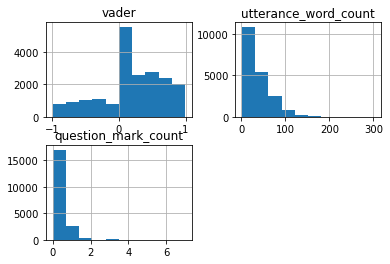

In [18]:
cluster_df.hist()

In [19]:
# cluster_df[
df[df.utterance_word_count == df.utterance_word_count.max()]

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2006-03-22,80266,102,mr. neill,"Well, the data is, Jay is right, the great maj...",talk of the nation,grading the use of graduation exams,False,"well , the data is , jay is right , the great ...","well , the data is , jay is right , the great ...",0.9859,302,0


In [20]:
# Scale the cluster_df

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(cluster_df)
cluster_df_scaled = pd.DataFrame(scaler.transform(cluster_df), columns= cluster_df.columns).set_index([cluster_df.index.values])


In [21]:
cluster_df_scaled.head()

,vader,utterance_word_count,question_mark_count
2005-01-11,-0.355621,-1.062217,-0.377135
2005-01-11,0.561913,0.047075,-0.377135
2005-01-11,0.073859,1.092979,-0.377135
2005-01-11,-0.355621,-0.650194,-0.377135
2005-01-26,-0.927145,-0.523418,1.737444


In [22]:
from sklearn.cluster import KMeans

In [23]:
# sklearn implementation of KMeans

#define the thing
kmeans_cluster_df_scaled = KMeans(n_clusters=3, random_state = 123, verbose = 0)

# fit the thing
kmeans_cluster_df_scaled.fit(cluster_df_scaled)

# Use (predict using) the thing 
kmeans_cluster_df_scaled.predict(cluster_df_scaled)

array([0, 2, 2, ..., 0, 2, 1], dtype=int32)

In [24]:
import matplotlib.pyplot as plt
import re, seaborn as sns
import numpy as np
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [25]:
cluster_df_scaled.columns

Index(['vader', 'utterance_word_count', 'question_mark_count'], dtype='object')

<IPython.core.display.Javascript object>


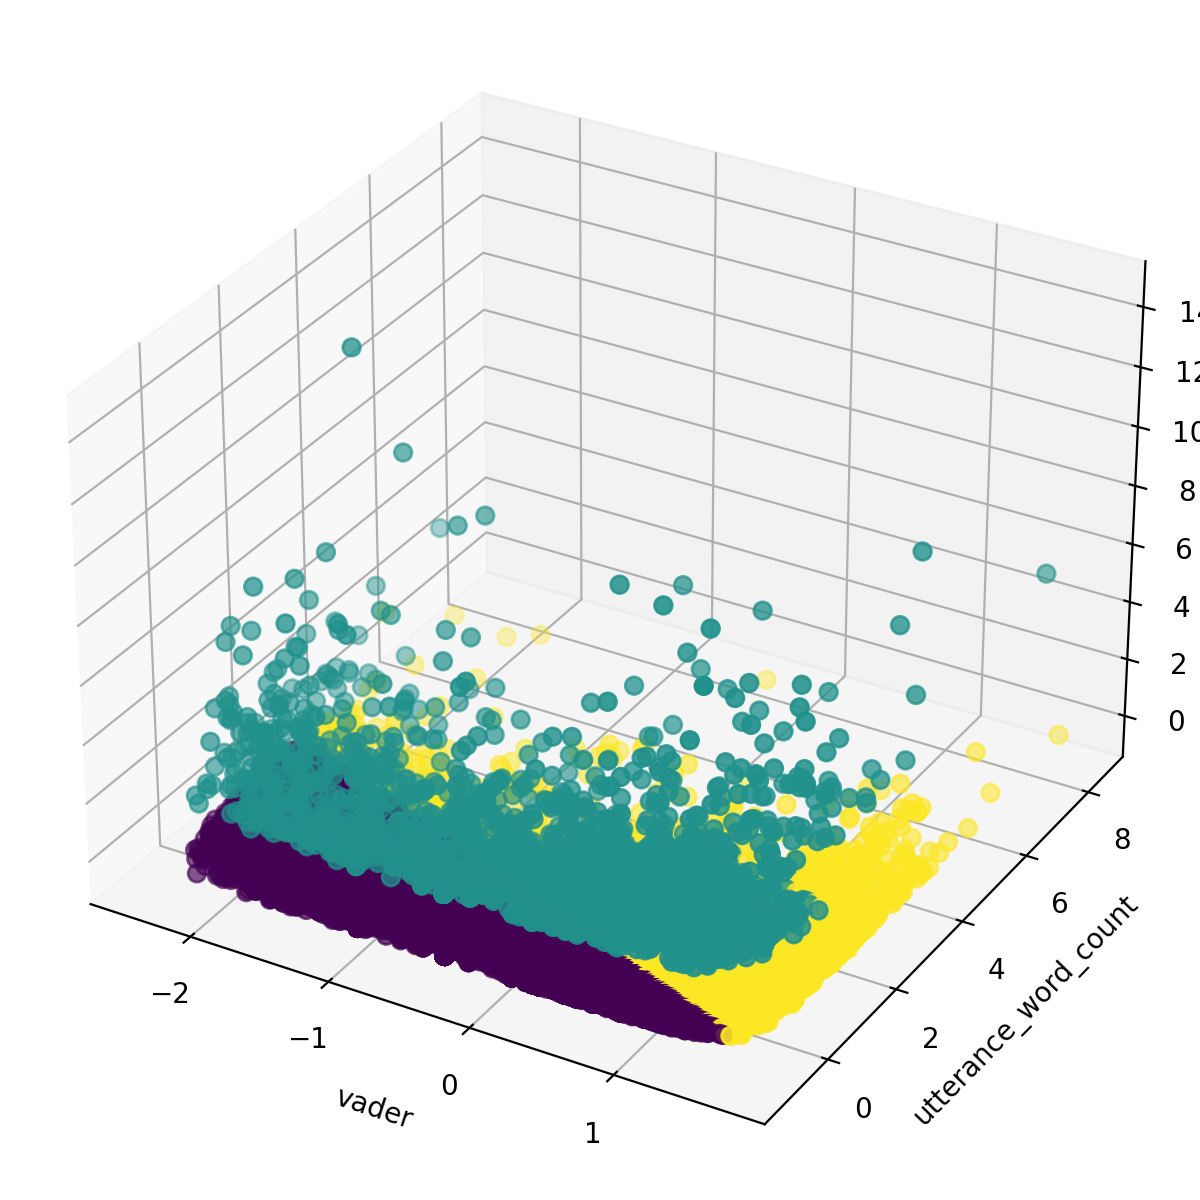

In [26]:
# The following command will make the graphic interactive
# but it creates problems for subsequent graphics and should be commented out 
# until it's being used

%matplotlib notebook



# assigning the graphing data
x = cluster_df_scaled.vader
y = cluster_df_scaled.utterance_word_count
z = cluster_df_scaled.question_mark_count
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
t = kmeans_cluster_df_scaled.predict(cluster_df_scaled)
# plot
# the x,y,z labels might need to be specific...
sc = ax.scatter(x, y, z, s=40, c=t, marker='o')#, cmap=t, alpha=1)
ax.set_xlabel('vader')
ax.set_ylabel('utterance_word_count')
ax.set_zlabel('question_mark_count')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

<IPython.core.display.Javascript object>


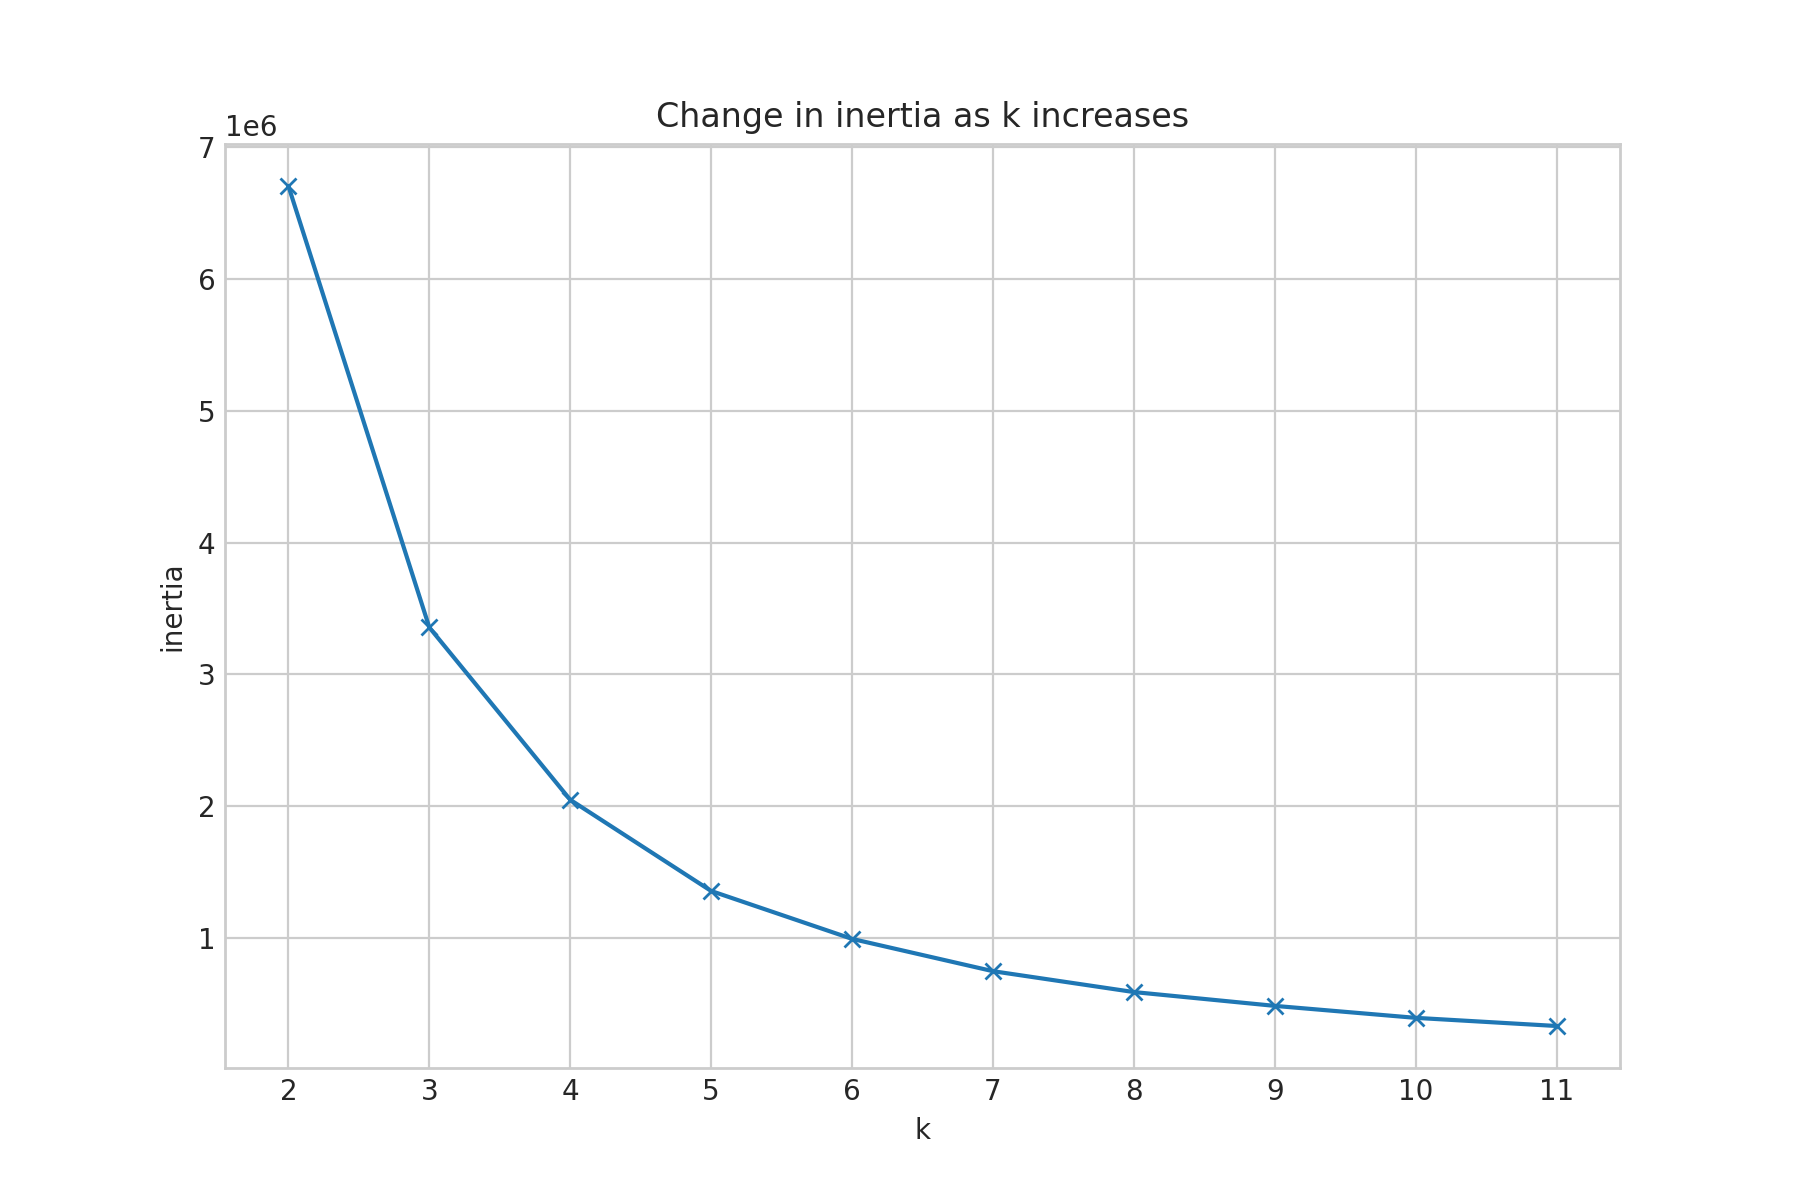

In [27]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(cluster_df).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')